In [12]:
from gnomepy.backtest.backtest import *
from gnomepy.backtest.strategy import *
from gnomepy.backtest.archive.signal import *
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [85]:
client = MarketDataClient(bucket="gnome-market-data-dev", aws_profile_name="AWSAdministratorAccess-443370708724")
client_data_params = {
    "exchange_id": 3,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 5, 21),
    "end_datetime": datetime.datetime(2025, 5, 22),
    "schema_type": SchemaType.MBP_10,
}


strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_mean_500_delta'], minimum_ticker_cycle=3, starting_cash=100000.0)]
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_00005'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta_alpha_0001'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_volatility_breakout'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_mean_reversion'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_rsi_strategy'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_macd_strategy'], minimum_ticker_cycle=3, starting_cash=100000.0),
            #   Strategy(name="Simple Strategy", action=global_actions['single_ticker_moving_average_crossover'], minimum_ticker_cycle=3, starting_cash=100000.0)]
# strategies = [Strategy(name="Simple Strategy", action=global_actions['single_ticker_rolling_exp_mean_delta'], minimum_ticker_cycle=3, starting_cash=100000.0),]

backtest_3 = Backtest(
    client=client,
    strategies=strategies,  # Pass a list of strategies
    exchange_id=client_data_params["exchange_id"],
    security_id=client_data_params["security_id"],
    start_datetime=client_data_params["start_datetime"],
    end_datetime=client_data_params["end_datetime"],
    schema_type=client_data_params["schema_type"]
)
backtest_3_df = backtest_3.run(data_type='pandas')

client_data_params = {
    "exchange_id": 4,
    "security_id": 1,
    "start_datetime": datetime.datetime(2025, 5, 21),
    "end_datetime": datetime.datetime(2025, 5, 22),
    "schema_type": SchemaType.MBP_10,
}

backtest_4 = Backtest(
    client=client,
    strategies=strategies,  # Pass a list of strategies
    exchange_id=client_data_params["exchange_id"],
    security_id=client_data_params["security_id"],
    start_datetime=client_data_params["start_datetime"],
    end_datetime=client_data_params["end_datetime"],
    schema_type=client_data_params["schema_type"]
)
backtest_4_df = backtest_4.run(data_type='pandas')

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_99123/2122725067.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
/var/folders/xs/59kj_n6d2qs33y

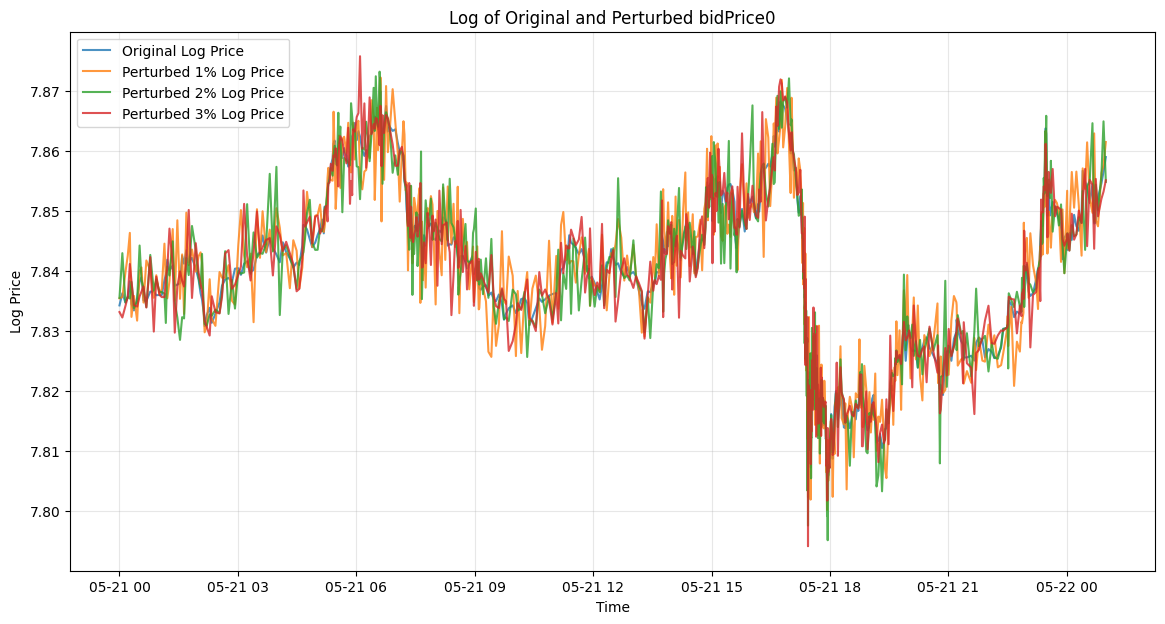

In [86]:
data = backtest_3_df[0][0]

# Calculate average spread between ask and bid
avg_spread = (data['askPrice0'] - data['bidPrice0']).mean()

# Create lagged signals with different lag lengths
lag_lengths = [100, 500, 600]  # Short, medium and long lags
n = len(data)

# Initialize perturbed series with original prices
data['bidPrice0_perturbed_1'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.05, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_2'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.05, size=len(data)) * (data['bidPrice0']/10)
data['bidPrice0_perturbed_3'] = data['bidPrice0'] + np.random.normal(loc=0, scale=0.05, size=len(data)) * (data['bidPrice0']/10)

# Initialize perturbed ask prices by adding spread to perturbed bid prices
data['askPrice0_perturbed_1'] = data['bidPrice0_perturbed_1'] + avg_spread
data['askPrice0_perturbed_2'] = data['bidPrice0_perturbed_2'] + avg_spread
data['askPrice0_perturbed_3'] = data['bidPrice0_perturbed_3'] + avg_spread

# Generate random lag points for each series
num_lags = n // 1000  # Create lags roughly every 100 ticks
lag_points = np.sort(np.random.choice(range(n-max(lag_lengths)), num_lags, replace=False))

# Apply lags at random points
for start_idx in lag_points:
    # For each lag length (short, medium, long)
    for i, lag in enumerate(lag_lengths, 1):
        # Get the lagged prices
        lagged_bid_price = data['bidPrice0'].iloc[start_idx-lag:start_idx-lag+lag].values
        lagged_ask_price = lagged_bid_price + avg_spread
        
        # Apply the lags to the corresponding perturbed series
        data[f'bidPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_bid_price
        data[f'askPrice0_perturbed_{i}'].iloc[start_idx:start_idx+lag] = lagged_ask_price

# Calculate log of prices
data['log_price'] = np.log(data['bidPrice0'])
data['log_price_perturbed_1'] = np.log(data['bidPrice0_perturbed_1'])
data['log_price_perturbed_2'] = np.log(data['bidPrice0_perturbed_2'])
data['log_price_perturbed_3'] = np.log(data['bidPrice0_perturbed_3'])

# Drop NaN values from all columns
data = data.dropna(subset=['log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3'], axis=0)

# Display the log prices, plotting every 10th point
plt.figure(figsize=(14, 7))
plt.plot(data['timestampEvent'][::1000], data['log_price'][::1000], label='Original Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_1'][::1000], label='Perturbed 1% Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_2'][::1000], label='Perturbed 2% Log Price', alpha=0.8)
plt.plot(data['timestampEvent'][::1000], data['log_price_perturbed_3'][::1000], label='Perturbed 3% Log Price', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Log Price')
plt.title('Log of Original and Perturbed bidPrice0')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [93]:
# Number of COins trading
n_coins = 4

# How often we recalculate beta vectors
beta_refresh_freq = 10000
beta_vectors = None

# Spread window - how many data points do we use for mean and std deviation of spread
spread_window = 100

# Starting 
long = False
short = False
position = np.zeros(n_coins) # Only trading 4 coins rn
cash = 10000 # Start with 10000 dollars
notional = 1000 # Trade 100 dollars each time, split amongst coins

# Track data
history = []

# Trade Freq
trade_freq = 20 # we look at every 20th tick

# Let's work through this ticker by ticker
for index, row in data.iterrows():


    if index % trade_freq == 0:
        # First check if we need to refresh betas
        if index % beta_refresh_freq == 0 and index != 0:
            
            # Create dataframe of all the relevant coins we would like to run johansen test on
            coin_basket_matrix = np.column_stack([data.loc[index-beta_refresh_freq:index, 'log_price'].values, data.loc[index-beta_refresh_freq:index, 'log_price_perturbed_1'].values, data.loc[index-beta_refresh_freq:index, 'log_price_perturbed_2'].values, data.loc[index-beta_refresh_freq:index, 'log_price_perturbed_3'].values])
            coin_basket_df = pd.DataFrame(coin_basket_matrix, columns=['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3'])

            # Run johansen test
            johansen_result = coint_johansen(coin_basket_matrix, det_order=0, k_ar_diff=1)

            # Compare trace statistics against critical values
            # If trace stat > critical value, reject null hypothesis and conclude more cointegrating relationships
            trace_stats = johansen_result.lr1
            cv_95 = johansen_result.cvt[:, 1]  # 95% critical values

            num_coints = 0
            for i in range(len(trace_stats)):
                if trace_stats[i] > cv_95[i]:
                    num_coints += 1

            beta_vectors = johansen_result.evec[:, :num_coints]

            continue

        # If we don't need to refresh, and already have some beta vectors to use
        elif beta_vectors is not None:

            spread = np.matrix(row[['log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3']]) @ beta_vectors[:,0]
            spread_mean = (np.array(data.loc[index-spread_window:index,['log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3']]) @ beta_vectors[:,0]).mean()
            spread_std = (np.array(data.loc[index-spread_window:index,['log_price', 'log_price_perturbed_1', 'log_price_perturbed_2', 'log_price_perturbed_3']]) @ beta_vectors[:,0]).std()
            z_score = (spread - spread_mean) / spread_std

            history_vector = [index, spread, spread_mean, spread_std, z_score, row['log_price'], row['log_price_perturbed_1'], row['log_price_perturbed_2'], row['log_price_perturbed_3']]

            # Normalized beta_vector for purchasing
            normalized_beta = beta_vectors[:,0] / np.linalg.norm(beta_vectors[:,0])
            notional_beta = notional * normalized_beta

            # Get real ask and bid prices
            ask_vector = np.array([row['askPrice0'], row['askPrice0_perturbed_1'], row['askPrice0_perturbed_2'], row['askPrice0_perturbed_3']])
            bid_vector = np.array([row['bidPrice0'], row['bidPrice0_perturbed_1'], row['bidPrice0_perturbed_2'], row['bidPrice0_perturbed_3']])

            # Get appropriate ask or bid depending on the direction (if positive (long), we must assume the ask)
            price_vector = np.array([ask_vector[i] if notional_beta[i] > 0 else bid_vector[i] for i in range(n_coins)])

            print(f"Notional Beta: {notional_beta}")
            # If I am long and the spread approaches zero, then exit
            if z_score > -0.3 and long:
                print("Exiting Long Position")
                cash += position.T @ price_vector
                print(f"Cash Remaining: {cash}")

                position = np.zeros(n_coins)  # Reset position to zero\
                long = False
                print(f"Exit Prices: {price_vector}")

            # If I am short and the spread approaches zero, then exit
            elif z_score > -0.3 and short:
                print("Exiting Short Position")
                cash += position.T @ price_vector
                print(f"Cash Remaining: {cash}")

                position = np.zeros(n_coins)  # Reset position to zero
                short = False
                print(f"Exit Prices: {price_vector}")


            # We should go long here
            elif z_score < -2:
                
                # First check if we are already long, if so double position
                if long:
                    print("Doubling Long Position")
                    position = position + (notional_beta / price_vector)
                    cash += position.T @ price_vector
                    print(f"Cash Remaining: {cash}")

                # Go long
                else:
                    print("Entering Long Position")
                    position = position + (notional_beta / price_vector)
                    cash += position.T @ price_vector
                    print(f"Cash Remaining: {cash}")

                    long = True
                    print(f"Entrance Prices: {price_vector}")


            # We should go short here
            elif z_score > 2:

                # First check if we are already long, if so double position
                if short:
                    print("Doubling Short Position")
                    position = position + (-notional_beta / price_vector)
                    cash += position.T @ price_vector
                    print(f"Cash Remaining: {cash}")


                # Go long
                else:
                    print("Entering Short Position")
                    position = position + (-notional_beta / price_vector)
                    short = True
                    cash += position.T @ price_vector

                    print(f"Entrance Prices: {price_vector}")
                    print(f"Cash Remaining: {cash}")
            

        # Not enough data yet to perform analysis
        else:
            continue
        



Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Entering Long Position
Cash Remaining: 9978.076026619983
Entrance Prices: [2527.4        2540.22866021 2532.48306735 2533.        ]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Doubling Long Position
Cash Remaining: 9933.231797843206
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Exiting Long Position
Cash Remaining: 9897.19422042118
Exit Prices: [2527.2        2527.7476614  2531.28306735 2533.        ]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.05219209 -713.48091822   86.69369177  -85.18893901]
Notional Beta: [ 690.0521920

KeyboardInterrupt: 

In [90]:
cash

np.float64(22306.04468517297)

In [74]:
new_history = np.array([[float(obj) if type(obj) is not int and isinstance(obj, (np.matrix, np.float64)) else obj for obj in element] for element in history])
new_history

/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_99123/4212962102.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_history = np.array([[float(obj) if type(obj) is not int and isinstance(obj, (np.matrix, np.float64)) else obj for obj in element] for element in history])


array([[ 1.00010000e+04, -2.22945764e+01, -2.27803641e+01, ...,
         7.83603618e+00,  7.83653341e+00,  7.83105027e+00],
       [ 1.00020000e+04, -2.26304815e+01, -2.27874875e+01, ...,
         7.83559659e+00,  7.83456416e+00,  7.83171309e+00],
       [ 1.00030000e+04, -2.41143395e+01, -2.28037239e+01, ...,
         7.83159924e+00,  7.81882133e+00,  7.82933419e+00],
       ...,
       [ 5.93200000e+05, -4.08042878e+01, -3.93582426e+01, ...,
         7.86017183e+00,  7.85083102e+00,  7.85766470e+00],
       [ 5.93201000e+05, -3.89413467e+01, -3.93728093e+01, ...,
         7.85710606e+00,  7.85769011e+00,  7.85781728e+00],
       [ 5.93202000e+05, -4.09308952e+01, -3.93740563e+01, ...,
         7.86255898e+00,  7.85364453e+00,  7.85865480e+00]],
      shape=(583144, 9))

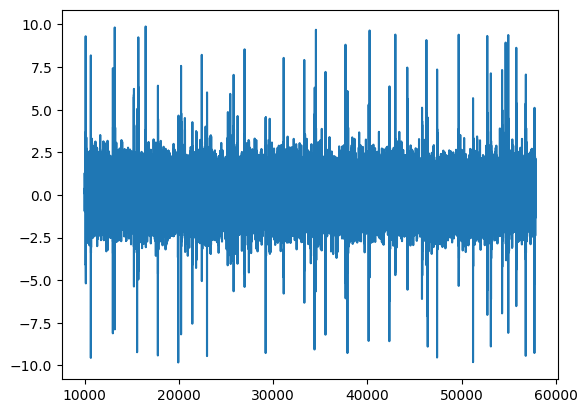

In [69]:
# plt.plot(new_history[:,0], new_history[:,1])
# plt.plot(new_history[:,0], new_history[:,2])
# plt.plot(new_history[:,0], new_history[:,3])
plt.plot(new_history[:,0], new_history[:,4])

In [145]:
coin_basket_matrix = np.column_stack([data['log_price'].values[::100], data['log_price_perturbed_1'].values[::100], data['log_price_perturbed_2'].values[::100], data['log_price_perturbed_3'].values[::100]])
# Calculate correlation matrix for the log prices
corr_matrix = np.corrcoef(coin_basket_matrix.T)

# Create a DataFrame for better visualization
corr_df = pd.DataFrame(
    corr_matrix, 
    columns=['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3'],
    index=['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3']
)

print("\nCorrelation Matrix of Log Prices:")
print(corr_df)



Correlation Matrix of Log Prices:
             Original  Perturbed_1  Perturbed_2  Perturbed_3
Original     1.000000     0.949451     0.964147     0.965808
Perturbed_1  0.949451     1.000000     0.915014     0.917448
Perturbed_2  0.964147     0.915014     1.000000     0.934851
Perturbed_3  0.965808     0.917448     0.934851     1.000000


In [146]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Create dataframe of all the relevant coins we would like to run johansen test on
coin_basket_matrix = np.column_stack([data['log_price'].values, data['log_price_perturbed_1'].values, data['log_price_perturbed_2'].values, data['log_price_perturbed_3'].values])
coin_basket_df = pd.DataFrame(coin_basket_matrix, columns=['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3'])

# Run johansen test
johansen_result = coint_johansen(coin_basket_matrix, det_order=0, k_ar_diff=1)

# Compare trace statistics against critical values
# If trace stat > critical value, reject null hypothesis and conclude more cointegrating relationships
trace_stats = johansen_result.lr1
cv_95 = johansen_result.cvt[:, 1]  # 95% critical values

num_coints = 0
for i in range(len(trace_stats)):
    if trace_stats[i] > cv_95[i]:
        num_coints += 1

beta_vectors = johansen_result.evec[:, :num_coints]
beta_vectors

array([[ 282.39036935,  -63.98704478, -470.42321304],
       [-296.73355599,    1.86915783,    7.2249497 ],
       [   8.10257881,  289.35185957,  191.72010516],
       [   6.22130298, -227.16731145,  271.62629336]])

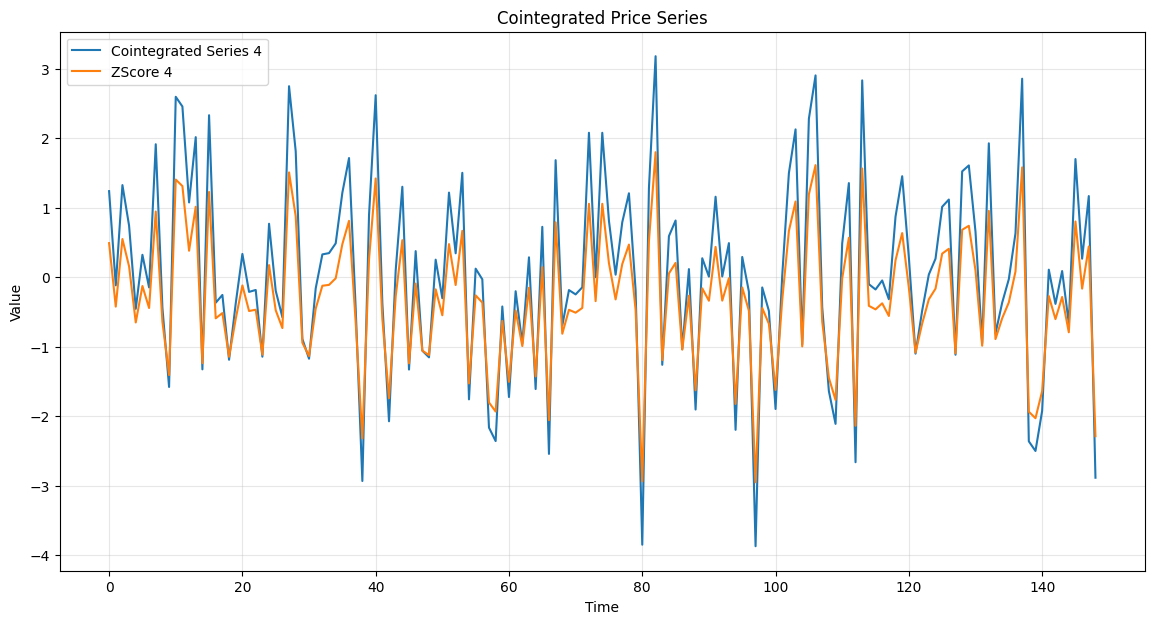

In [151]:
# Calculate the cointegrated series
spread = coin_basket_matrix @ beta_vectors
z_score = (spread - spread.mean()) / spread.std()

# Plot the cointegrated series
plt.figure(figsize=(14, 7))
# for i in range(cointegrated_series.shape[1]):
plt.plot(spread[::4000, 0], label=f'Cointegrated Series {i+1}')
plt.plot(z_score[::4000, 0], label=f'ZScore {i+1}')
plt.title('Cointegrated Price Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [5]:
# Test cointegration of the perturbed signals using Johansen cointegration test:

print("COINTEGRATION ANALYSIS OF PERTURBED SIGNALS")
print("=" * 50)

# Import required libraries for cointegration tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
import time

# Get the price series for cointegration testing
original_prices = backtest_3_df[0][0]['bidPrice0'].values[:100000]
perturbed_1 = backtest_3_df[0][0]['bidPrice0_perturbed_1'].values[:100000]
perturbed_2 = backtest_3_df[0][0]['bidPrice0_perturbed_2'].values[:100000]
perturbed_3 = backtest_3_df[0][0]['bidPrice0_perturbed_3'].values[:100000]

print("\n1. JOHANSEN COINTEGRATION TEST:")
print("-" * 40)

# Measure timing for Johansen test
johansen_start_time = time.time()

# Prepare data for Johansen test (all series together)
# We have 4 vectors because we're testing 4 time series:
# 1. Original bidPrice0 (the baseline price series)
# 2. Perturbed_1 (original + 0.05% noise)
# 3. Perturbed_2 (original + 10% noise) 
# 4. Perturbed_3 (original + 15% noise)
# Each vector represents one price series, and we want to test if they move together long-term
data_matrix = np.column_stack([original_prices, perturbed_1, perturbed_2, perturbed_3])
data_df = pd.DataFrame(data_matrix, columns=['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3'])

print(f"Testing cointegration among {data_matrix.shape[1]} price series (vectors):")
print(f"  - Original bidPrice0")
print(f"  - Perturbed version 1 (0.05% noise)")
print(f"  - Perturbed version 2 (10% noise)")
print(f"  - Perturbed version 3 (15% noise)")
print(f"Each series has {data_matrix.shape[0]} observations\n")

# Perform Johansen test
johansen_result = coint_johansen(data_matrix, det_order=0, k_ar_diff=1)

johansen_end_time = time.time()
johansen_duration = johansen_end_time - johansen_start_time

# Interpret Johansen test results
print(f"Test completed in {johansen_duration:.3f} seconds\n")

# Check for cointegration at 5% significance level
trace_stats = johansen_result.lr1
critical_values_5pct = johansen_result.cvt[:, 1]  # 5% critical values

print("JOHANSEN TEST RESULTS:")
print("Trace Statistics vs Critical Values (5% significance):")
for i in range(len(trace_stats)):
    is_cointegrated = trace_stats[i] > critical_values_5pct[i]
    print(f"  H{i}: {trace_stats[i]:.2f} vs {critical_values_5pct[i]:.2f} - {'COINTEGRATED' if is_cointegrated else 'NOT COINTEGRATED'}")

# Count cointegrating relationships
num_coint_relationships = sum(trace_stats > critical_values_5pct)

print(f"\nCOINTEGRATING VECTORS (Eigenvectors):")
print("Note: Each eigenvector shows the linear combination weights for the 4 price series")
signal_names = ['Original', 'Perturbed_1', 'Perturbed_2', 'Perturbed_3']
for i in range(num_coint_relationships):
    print(f"\nCointegrating Relationship {i+1}:")
    eigenvector = johansen_result.evec[:, i]
    for j, name in enumerate(signal_names):
        print(f"  {name}: {eigenvector[j]:.4f}")
    
    # Identify which signals are most strongly related in this relationship
    abs_weights = np.abs(eigenvector)
    dominant_signals = [signal_names[k] for k in np.where(abs_weights > 0.1)[0]]
    print(f"  Dominant signals in this relationship: {', '.join(dominant_signals)}")

print(f"\nSUMMARY:")
print(f"Number of cointegrating relationships found: {num_coint_relationships}")

if num_coint_relationships == 4:
    print("RESULT: All signals are cointegrated - they form a complete cointegrated system.")
    print("This means all perturbed versions maintain long-term equilibrium with the original.")
elif num_coint_relationships > 0:
    print(f"RESULT: {num_coint_relationships} cointegrating relationships exist.")
    print("Check the eigenvectors above to see which specific signals are cointegrated.")
else:
    print("RESULT: No cointegration detected among the signals.")




COINTEGRATION ANALYSIS OF PERTURBED SIGNALS

1. JOHANSEN COINTEGRATION TEST:
----------------------------------------
Testing cointegration among 4 price series (vectors):
  - Original bidPrice0
  - Perturbed version 1 (0.05% noise)
  - Perturbed version 2 (10% noise)
  - Perturbed version 3 (15% noise)
Each series has 100000 observations

Test completed in 0.076 seconds

JOHANSEN TEST RESULTS:
Trace Statistics vs Critical Values (5% significance):
  H0: 121443.69 vs 47.85 - COINTEGRATED
  H1: 80695.97 vs 29.80 - COINTEGRATED
  H2: 40004.11 vs 15.49 - COINTEGRATED
  H3: 0.06 vs 3.84 - NOT COINTEGRATED

COINTEGRATING VECTORS (Eigenvectors):
Note: Each eigenvector shows the linear combination weights for the 4 price series

Cointegrating Relationship 1:
  Original: 8.8852
  Perturbed_1: -8.8828
  Perturbed_2: -0.0197
  Perturbed_3: 0.0177
  Dominant signals in this relationship: Original, Perturbed_1

Cointegrating Relationship 2:
  Original: -0.8466
  Perturbed_1: 0.9128
  Perturbed_2: 

/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/vecm.py:730: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/vecm.py:732: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])
/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/vecm.py:730: RuntimeWarning: divide by zero encountered in log
  tmp = np.log(iota - a)[i:]
/Users/andrewannetrand/Desktop/gnomepy/.venv/lib/python3.13/site-packages/statsmodels/tsa/vector_ar/vecm.py:732: RuntimeWarning: divide by zero encountered in log
  lr2[i] = -t * np.log(1 - a[i])


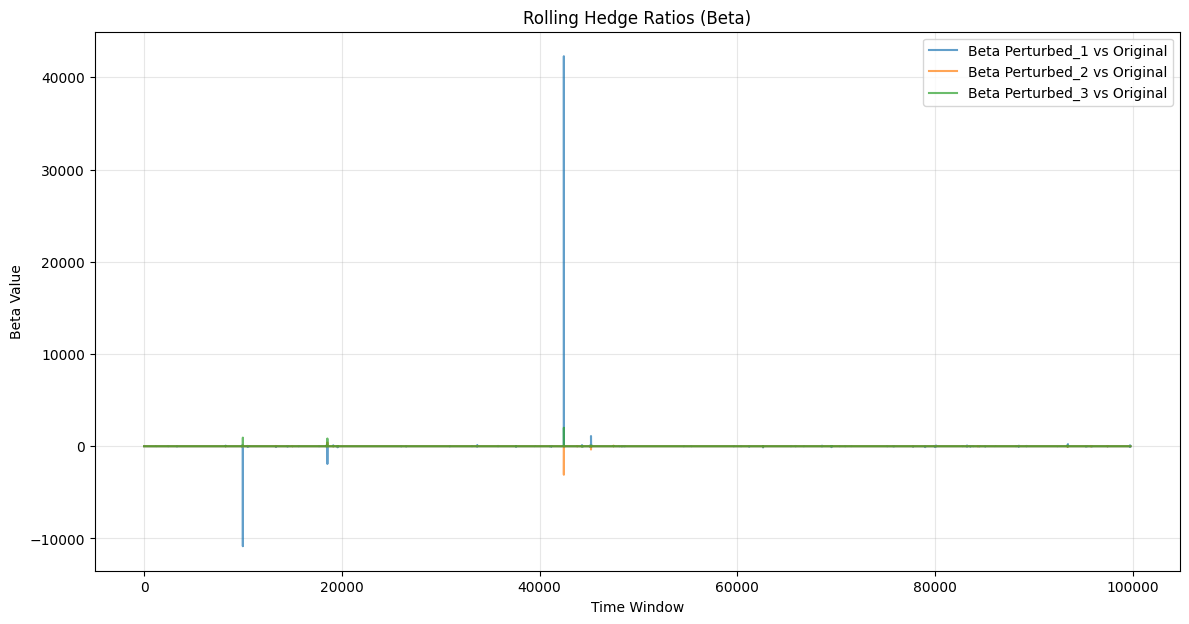

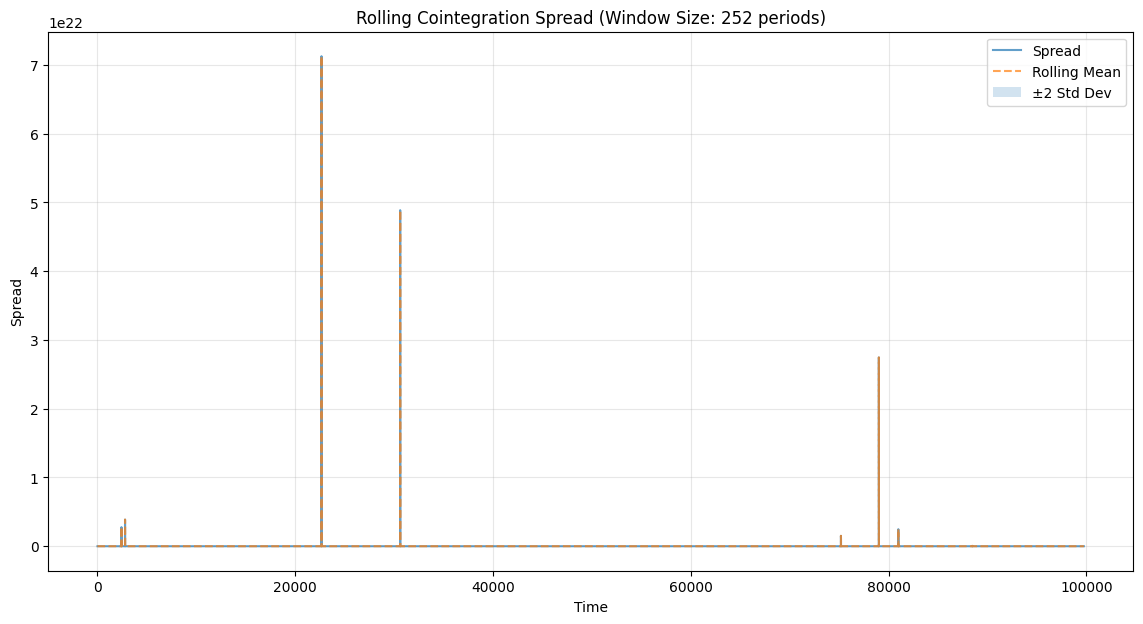


FINAL PERIOD STATISTICS:
Hedge Ratios (Beta):
Perturbed_1 vs Original: 1.4526
Perturbed_2 vs Original: -0.0382
Perturbed_3 vs Original: -0.1064

Spread Mean: -289.2758
Spread Std Dev: 1.5234
Current Z-Score: -0.94


In [7]:
# Calculate beta (hedge ratio) using the first cointegrating vector
if num_coint_relationships > 0:
    # Initialize arrays for rolling calculations
    window_size = 252  # One trading year
    rolling_spreads = np.zeros((data_matrix.shape[0] - window_size + 1, 1))
    rolling_betas = np.zeros((data_matrix.shape[0] - window_size + 1, len(signal_names)-1))
    rolling_means = np.zeros(data_matrix.shape[0] - window_size + 1)
    rolling_stds = np.zeros(data_matrix.shape[0] - window_size + 1)
    
    # Calculate rolling values
    for i in range(len(rolling_spreads)):
        window_data = data_matrix[i:i+window_size]
        
        # Calculate rolling Johansen test
        try:
            rolling_johansen = coint_johansen(window_data, det_order=0, k_ar_diff=1)
        except np.linalg.LinAlgError:
            # Handle singular matrix error by skipping this window
            rolling_johansen = None
            continue
        if rolling_johansen is None:
            continue
        
        # Calculate rolling betas
        rolling_betas[i] = -rolling_johansen.evec[1:, 0] / rolling_johansen.evec[0, 0]
        
        # Calculate rolling spread
        spread = np.zeros(window_size)
        for j in range(window_data.shape[1]):
            spread += rolling_johansen.evec[j, 0] * window_data[:, j]
            
        rolling_spreads[i] = spread[-1]  # Store only the last value
        rolling_means[i] = np.mean(spread)
        rolling_stds[i] = np.std(spread)
    
    # Plot rolling betas
    plt.figure(figsize=(14, 7))
    for i, name in enumerate(signal_names[1:]):
        plt.plot(rolling_betas[:, i], label=f'Beta {name} vs Original', alpha=0.7)
    plt.title('Rolling Hedge Ratios (Beta)')
    plt.xlabel('Time Window')
    plt.ylabel('Beta Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Plot rolling spread with bands
    plt.figure(figsize=(14, 7))
    plt.plot(rolling_spreads, label='Spread', alpha=0.7)
    plt.plot(rolling_means, label='Rolling Mean', linestyle='--', alpha=0.7)
    plt.fill_between(range(len(rolling_spreads)), 
                     rolling_means - 2*rolling_stds,
                     rolling_means + 2*rolling_stds,
                     alpha=0.2, label='±2 Std Dev')
    plt.title(f'Rolling Cointegration Spread (Window Size: {window_size} periods)')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    # Print final period statistics
    print("\nFINAL PERIOD STATISTICS:")
    print("Hedge Ratios (Beta):")
    for i, name in enumerate(signal_names[1:]):
        print(f"{name} vs Original: {rolling_betas[-1, i]:.4f}")
    print(f"\nSpread Mean: {rolling_means[-1]:.4f}")
    print(f"Spread Std Dev: {rolling_stds[-1]:.4f}")
    current_zscore = (rolling_spreads[-1] - rolling_means[-1]) / rolling_stds[-1]
    print(f"Current Z-Score: {current_zscore[0]:.2f}")
else:
    print("\nNo cointegrating relationships found - cannot calculate hedge ratios and spread.")

313671
Correlation between bidPrice0 of backtest_3_df and backtest_4_df: 0.016279


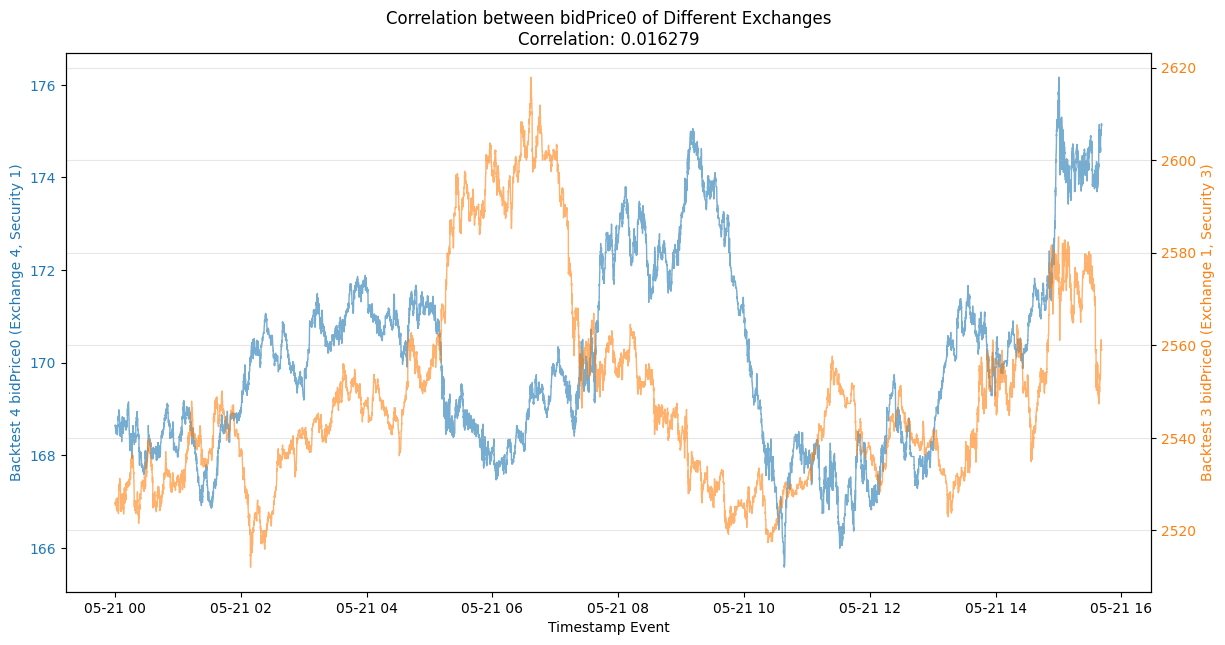

In [ ]:
# Calculate correlation between bidPrice0 of backtest_3_df and backtest_4_df
import numpy as np

# Ensure both dataframes have the same length by taking the minimum
min_length = min(len(backtest_3_df[0][0]), len(backtest_4_df[0][0]))
print(min_length)
backtest_3_prices = backtest_3_df[0][0]['bidPrice0'][:min_length]
backtest_4_prices = backtest_4_df[0][0]['bidPrice0'][:min_length]

# Calculate correlation
correlation = np.corrcoef(backtest_3_prices, backtest_4_prices)[0, 1]
print(f"Correlation between bidPrice0 of backtest_3_df and backtest_4_df: {correlation:.6f}")

# Plot the two bidPrices against each other
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot backtest_4_prices on the left y-axis
color = 'tab:blue'
ax1.set_xlabel('Timestamp Event')
ax1.set_ylabel('Backtest 4 bidPrice0 (Exchange 4, Security 1)', color=color)
ax1.plot(backtest_3_df[0][0]['timestampEvent'][:min_length], backtest_4_prices, alpha=0.6, linewidth=1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for backtest_3_prices
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Backtest 3 bidPrice0 (Exchange 1, Security 3)', color=color)
ax2.plot(backtest_3_df[0][0]['timestampEvent'][:min_length], backtest_3_prices, alpha=0.6, linewidth=1, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title(f'Correlation between bidPrice0 of Different Exchanges\nCorrelation: {correlation:.6f}')
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
outputs_list = backtest.run(data_type='pandas')

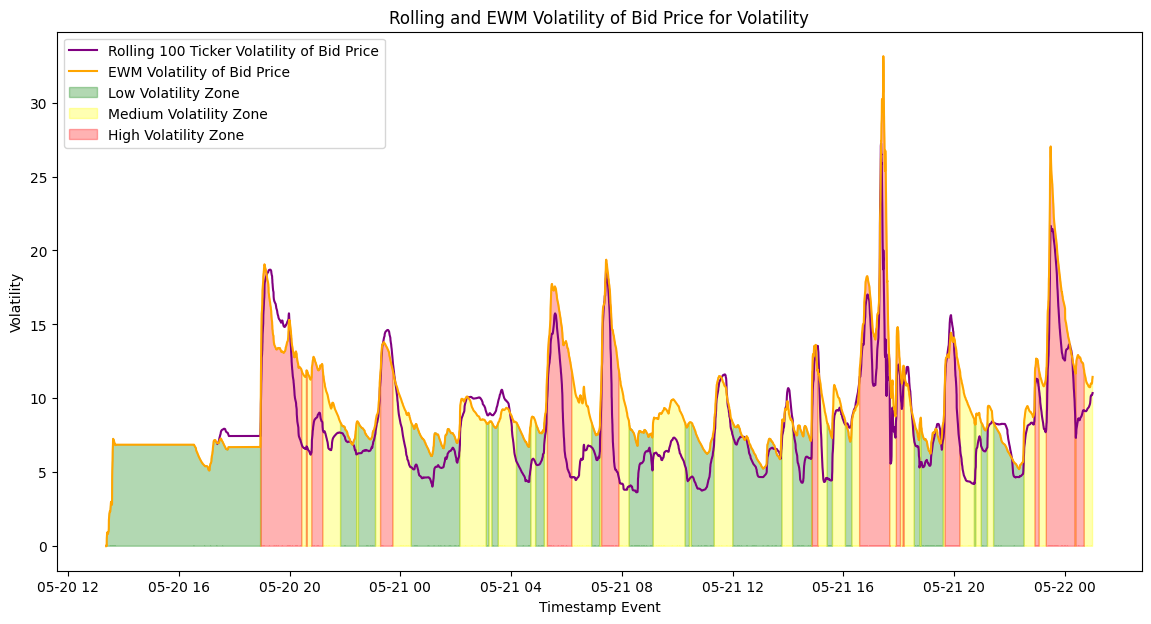

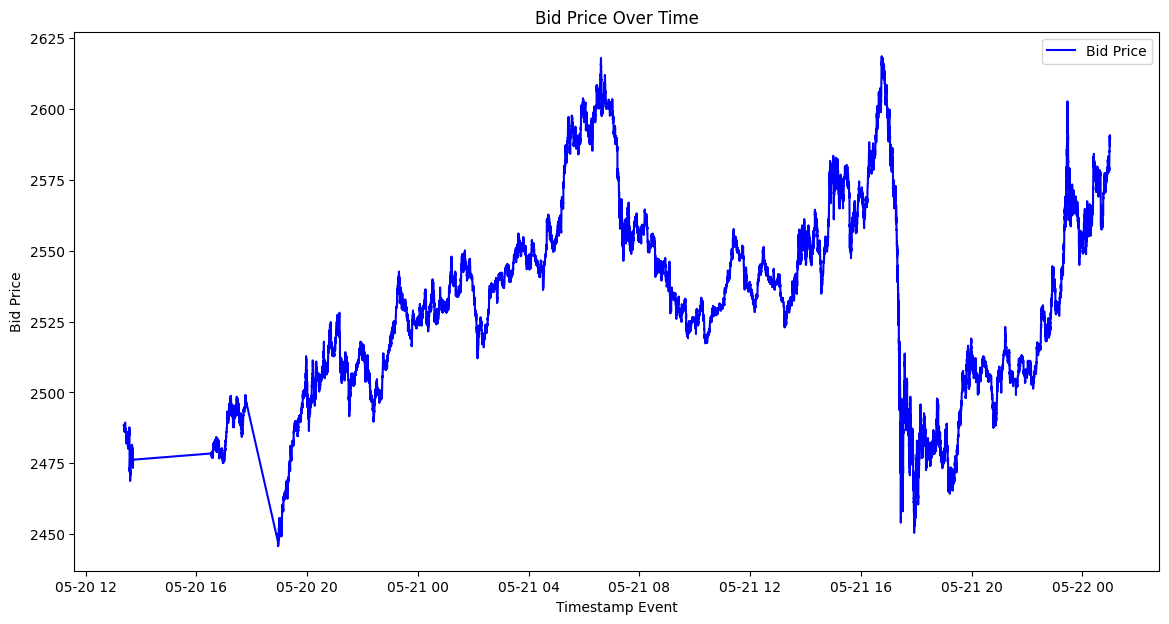

In [19]:
import matplotlib.pyplot as plt

# Calculate the rolling and exponentially weighted moving average (ewm) volatility of bidPrice0
action_name = "Volatility"
output_df = outputs_list[0][0]

# Calculate rolling volatility
rolling_volatility = output_df['bidPrice0'].rolling(window=20000).std()

# Calculate exponentially weighted moving average volatility
ewm_volatility = output_df['bidPrice0'].ewm(span=20000, adjust=False).std()

# Classify each row into volatility categories based on ewm volatility
volatility_thresholds = ewm_volatility.quantile([0.33, 0.66])
output_df['volatility_category'] = pd.cut(
    ewm_volatility,
    bins=[-float('inf'), volatility_thresholds[0.33], volatility_thresholds[0.66], float('inf')],
    labels=['low', 'medium', 'high']
)

# Plot the rolling and ewm volatility with zones
plt.figure(figsize=(14, 7))
plt.plot(output_df['timestampEvent'], rolling_volatility, label='Rolling 100 Ticker Volatility of Bid Price', color='purple')
plt.plot(output_df['timestampEvent'], ewm_volatility, label='EWM Volatility of Bid Price', color='orange')


# Highlight the volatility zones
plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'low', color='green', alpha=0.3, label='Low Volatility Zone')
plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'medium', color='yellow', alpha=0.3, label='Medium Volatility Zone')
plt.fill_between(output_df['timestampEvent'], 0, ewm_volatility, where=output_df['volatility_category'] == 'high', color='red', alpha=0.3, label='High Volatility Zone')

plt.xlabel('Timestamp Event')
plt.ylabel('Volatility')
plt.title(f'Rolling and EWM Volatility of Bid Price for {action_name}')
plt.legend()
plt.show()

# %% cell 4.5 code

# Plot bidPrice0 below the volatility graph
plt.figure(figsize=(14, 7))
plt.plot(output_df['timestampEvent'], output_df['bidPrice0'], label='Bid Price', color='blue')
plt.xlabel('Timestamp Event')
plt.ylabel('Bid Price')
plt.title('Bid Price Over Time')
plt.legend()
plt.show()


In [ ]:
# Cointegration Trading Strategy Explanation

print("=== COINTEGRATION TRADING STRATEGY EXPLANATION ===")
print()

print("HIGH-LEVEL OVERVIEW:")
print("Cointegration is a statistical relationship between two or more time series that")
print("tend to move together over the long term, even though they may diverge in the short term.")
print("As a hedge fund manager, this creates pairs trading opportunities where we can profit")
print("from temporary divergences while maintaining market-neutral exposure.")
print()

print("DETAILED EXPLANATION:")
print()

print("1. CONCEPT:")
print("   - Two assets are cointegrated if their price difference is stationary")
print("   - Even if individual prices are non-stationary (trending), their spread reverts to mean")
print("   - Creates predictable trading opportunities when the spread deviates from equilibrium")
print()

print("2. MATHEMATICAL FOUNDATION:")
print("   - If Price_A and Price_B are cointegrated:")
print("   - Spread = Price_A - β × Price_B (where β is the hedge ratio)")
print("   - The spread follows a mean-reverting process")
print("   - When spread > mean + threshold: Short A, Long B")
print("   - When spread < mean - threshold: Long A, Short B")
print()

print("3. TRADING MECHANISM:")
print("   Step 1: Identify cointegrated pairs using statistical tests (Engle-Granger, Johansen)")
print("   Step 2: Calculate the hedge ratio (β) using regression or error correction models")
print("   Step 3: Monitor the spread = Price_A - β × Price_B")
print("   Step 4: Enter positions when spread deviates significantly from mean")
print("   Step 5: Exit when spread reverts to mean")
print()

print("4. HEDGE FUND IMPLEMENTATION:")
print("   ADVANTAGES:")
print("   - Market-neutral strategy (hedged against market direction)")
print("   - Statistical edge based on mean reversion")
print("   - Lower volatility than directional strategies")
print("   - Scalable across multiple pairs")
print("   - Works in various market conditions")
print()
print("   CHALLENGES:")
print("   - Cointegration relationships can break down")
print("   - Requires sophisticated statistical analysis")
print("   - Transaction costs can erode profits")
print("   - Need real-time monitoring of multiple pairs")
print("   - Risk of prolonged divergence before convergence")
print()

print("5. REAL-WORLD EXAMPLE - CURRENCY PAIRS:")
print("   Consider EUR/USD and GBP/USD:")
print("   - Both influenced by USD strength/weakness")
print("   - Economic ties between EUR and GBP create cointegration")
print()
print("   Historical Analysis:")
print("   - EUR/USD = 1.1000, GBP/USD = 1.3000")
print("   - Hedge ratio (β) = 0.85 (from regression analysis)")
print("   - Normal spread = 1.1000 - 0.85 × 1.3000 = 0.0950")
print()
print("   Trading Opportunity:")
print("   - Current: EUR/USD = 1.0800, GBP/USD = 1.3200")
print("   - Current spread = 1.0800 - 0.85 × 1.3200 = -0.0420")
print("   - Spread is 0.137 below normal (significant deviation)")
print("   - Trade: Long EUR/USD, Short GBP/USD")
print("   - Exit when spread returns to ~0.095")
print()

print("6. STATISTICAL TESTS & IMPLEMENTATION:")
print("   A. Engle-Granger Test:")
print("      - Regress Price_A on Price_B")
print("      - Test residuals for stationarity using ADF test")
print("      - If residuals are stationary, pairs are cointegrated")
print()
print("   B. Johansen Test:")
print("      - Tests for multiple cointegrating relationships")
print("      - More robust for multiple time series")
print("      - Provides cointegrating vectors directly")
print()
print("   C. Error Correction Model:")
print("      - ΔPrice_A = α × (Price_A - β × Price_B)_{t-1} + noise")
print("      - α measures speed of mean reversion")
print("      - Higher |α| indicates faster convergence")
print()

print("7. RISK MANAGEMENT:")
print("   - Position sizing based on historical volatility of spread")
print("   - Stop-loss when spread exceeds historical extremes")
print("   - Regular re-estimation of cointegration parameters")
print("   - Monitoring for structural breaks in relationships")
print("   - Diversification across multiple cointegrated pairs")
print()

print("8. ADVANCED APPLICATIONS:")
print("   A. Multi-Asset Cointegration:")
print("      - Basket of currencies vs. single currency")
print("      - Sector rotation strategies")
print("      - Cross-asset cointegration (bonds vs. stocks)")
print()
print("   B. Dynamic Hedge Ratios:")
print("      - Kalman filters for time-varying relationships")
print("      - Rolling window estimation")
print("      - Regime-switching models")
print()
print("   C. High-Frequency Implementation:")
print("      - Intraday cointegration patterns")
print("      - Tick-by-tick spread monitoring")
print("      - Latency arbitrage opportunities")
print()

print("9. COMPARISON TO TRIANGULAR ARBITRAGE:")
print("   TRIANGULAR ARBITRAGE:")
print("   - Risk-free, immediate profit")
print("   - Requires perfect execution")
print("   - Opportunities are rare and fleeting")
print()
print("   COINTEGRATION TRADING:")
print("   - Statistical edge, not risk-free")
print("   - Longer holding periods")
print("   - More frequent opportunities")
print("   - Requires sophisticated modeling")
print()

print("10. PRACTICAL EXAMPLE - IMPLEMENTATION STEPS:")
print("    # Step 1: Data Collection")
print("    eur_usd = get_price_data('EUR/USD')")
print("    gbp_usd = get_price_data('GBP/USD')")
print()
print("    # Step 2: Test for Cointegration")
print("    from statsmodels.tsa.stattools import coint")
print("    score, pvalue, _ = coint(eur_usd, gbp_usd)")
print()
print("    # Step 3: Calculate Hedge Ratio")
print("    hedge_ratio = np.polyfit(gbp_usd, eur_usd, 1)[0]")
print()
print("    # Step 4: Calculate Spread")
print("    spread = eur_usd - hedge_ratio * gbp_usd")
print()
print("    # Step 5: Generate Signals")
print("    z_score = (spread - spread.mean()) / spread.std()")
print("    signals = np.where(z_score > 2, -1,  # Short spread")
print("                      np.where(z_score < -2, 1, 0))  # Long spread")
print()

print("As a hedge fund manager, cointegration strategies offer a more sustainable")
print("approach than pure arbitrage. While not risk-free, they provide statistical")
print("edges that can be systematically exploited with proper risk management,")
print("making them a cornerstone of many quantitative hedge fund strategies.")


=== COINTEGRATION TRADING STRATEGY EXPLANATION ===

HIGH-LEVEL OVERVIEW:
Cointegration is a statistical relationship between two or more time series that
tend to move together over the long term, even though they may diverge in the short term.
As a hedge fund manager, this creates pairs trading opportunities where we can profit
from temporary divergences while maintaining market-neutral exposure.

DETAILED EXPLANATION:

1. CONCEPT:
   - Two assets are cointegrated if their price difference is stationary
   - Even if individual prices are non-stationary (trending), their spread reverts to mean
   - Creates predictable trading opportunities when the spread deviates from equilibrium

2. MATHEMATICAL FOUNDATION:
   - If Price_A and Price_B are cointegrated:
   - Spread = Price_A - β × Price_B (where β is the hedge ratio)
   - The spread follows a mean-reverting process
   - When spread > mean + threshold: Short A, Long B
   - When spread < mean - threshold: Long A, Short B

3. TRADING MECH

In [28]:
output_df = outputs_list[1][0]

In [29]:
output_df

,exchangeId,securityId,timestampEvent,timestampSent,timestampRecv,price,size,action,side,flags,...,bidCount9,askCount9,cash,single_ticker_rolling_exp_mean_delta_alpha_00005_action,single_ticker_rolling_exp_mean_delta_alpha_00005_position,single_ticker_rolling_exp_mean_delta_alpha_00005_realized_action,single_ticker_rolling_exp_mean_delta_alpha_00005_cash_action,single_ticker_rolling_exp_mean_delta_alpha_00005_cash_balance,single_ticker_rolling_exp_mean_delta_alpha_00005_equity_position,volatility_category
0,1,3,2025-05-20 13:22:36.434000+00:00,NaT,2025-05-20 13:22:36.636561893+00:00,NaN,NaN,b'M',b'N',16,...,8,15,100000.0,0,0,0.0,0.0,100000.0,0.0,NaN
1,1,3,2025-05-20 13:22:29.073000+00:00,NaT,2025-05-20 13:22:36.644885294+00:00,2487.9,1.2061,b'T',b'B',16,...,8,15,100000.0,0,0,0.0,0.0,100000.0,0.0,low
2,1,3,2025-05-20 13:22:29.073000+00:00,NaT,2025-05-20 13:22:36.644885294+00:00,2487.9,1.2061,b'T',b'B',16,...,8,15,100000.0,0,0,0.0,0.0,100000.0,0.0,low
3,1,3,2025-05-20 13:22:29.257000+00:00,NaT,2025-05-20 13:22:36.644885294+00:00,2487.9,0.1830,b'T',b'B',16,...,8,15,100000.0,0,0,0.0,0.0,100000.0,0.0,low
4,1,3,2025-05-20 13:22:29.313000+00:00,NaT,2025-05-20 13:22:36.644885294+00:00,2487.9,0.2200,b'T',b'B',16,...,8,15,100000.0,0,0,0.0,0.0,100000.0,0.0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710639,1,3,2025-05-22 00:59:58.876000+00:00,NaT,2025-05-22 00:59:59.172797320+00:00,2589.3,0.1934,b'M',b'N',16,...,4,7,100000.0,0,0,0.0,0.0,115597.1,-6.0,medium
710640,1,3,2025-05-22 00:59:58.936000+00:00,NaT,2025-05-22 00:59:59.250580603+00:00,2589.4,0.1036,b'T',b'B',16,...,4,7,100000.0,0,0,0.0,0.0,115597.1,-6.0,medium
710641,1,3,2025-05-22 00:59:58.936000+00:00,NaT,2025-05-22 00:59:59.250580603+00:00,2589.4,1.1048,b'T',b'B',16,...,4,7,100000.0,0,0,0.0,0.0,115597.1,-6.0,medium
710642,1,3,2025-05-22 00:59:59.010000+00:00,NaT,2025-05-22 00:59:59.251330237+00:00,2589.4,0.0555,b'T',b'B',16,...,4,7,100000.0,0,0,0.0,0.0,115597.1,-6.0,medium


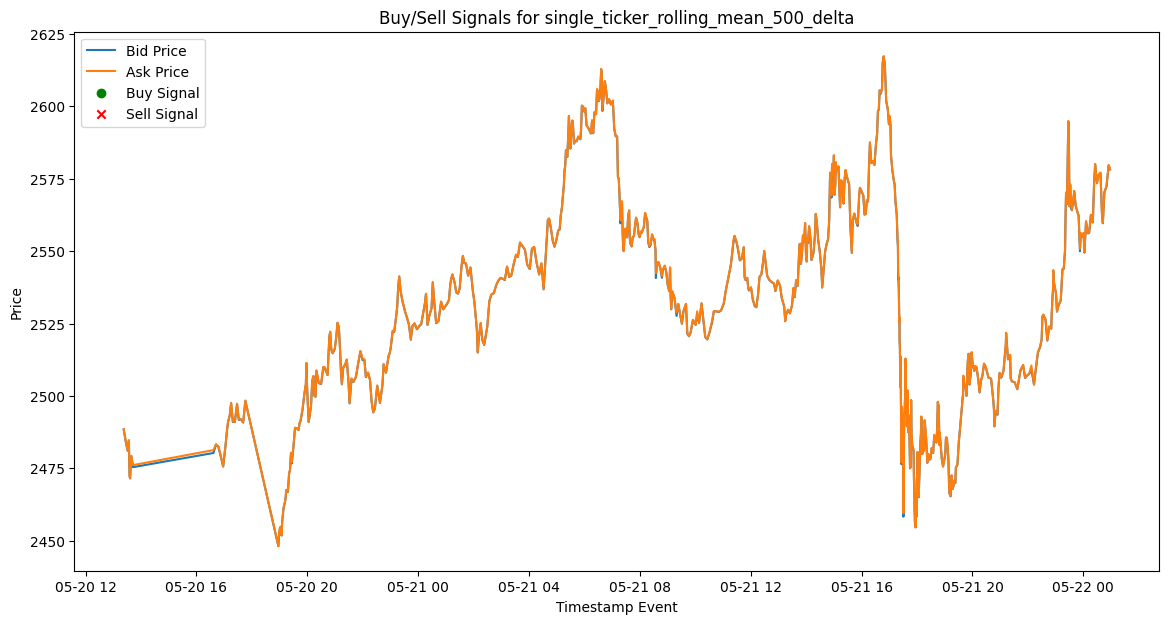

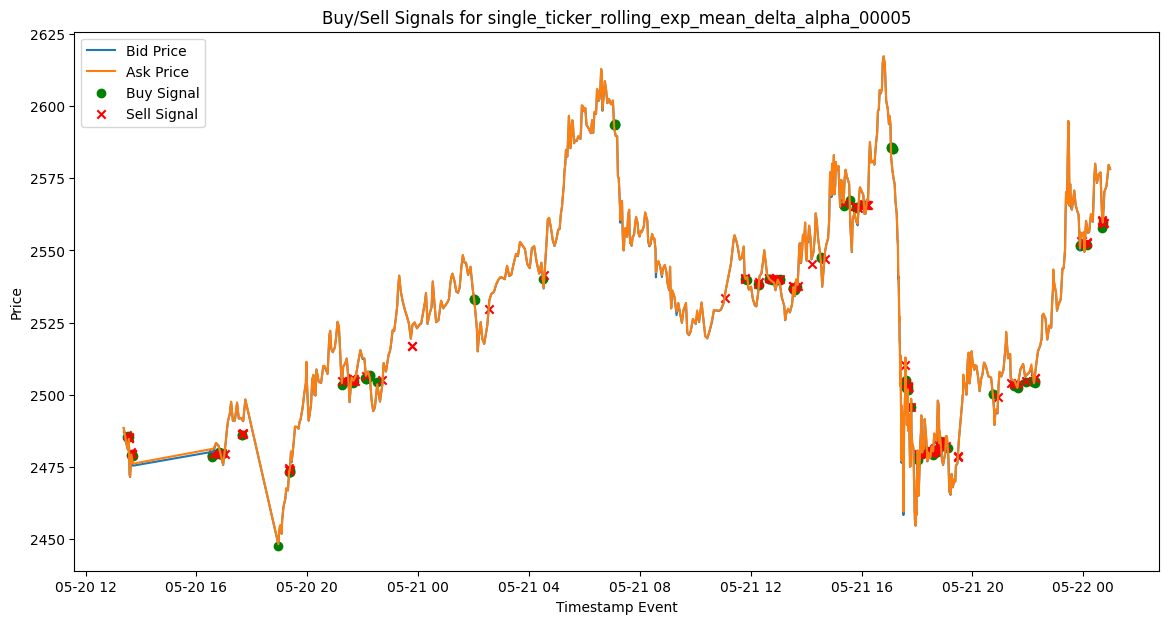

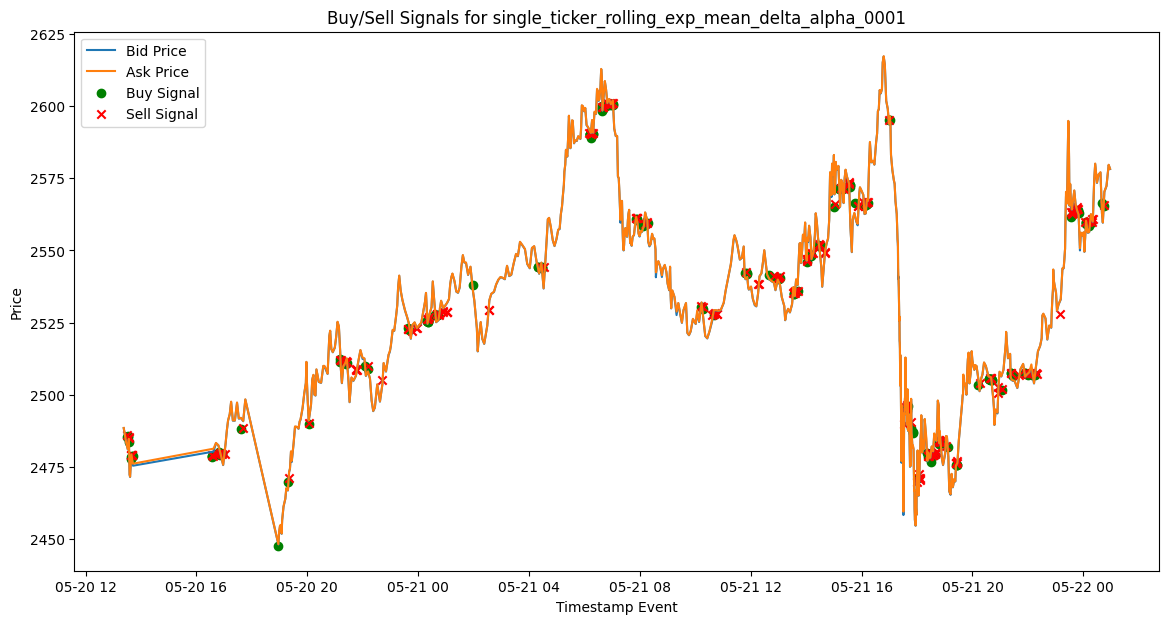

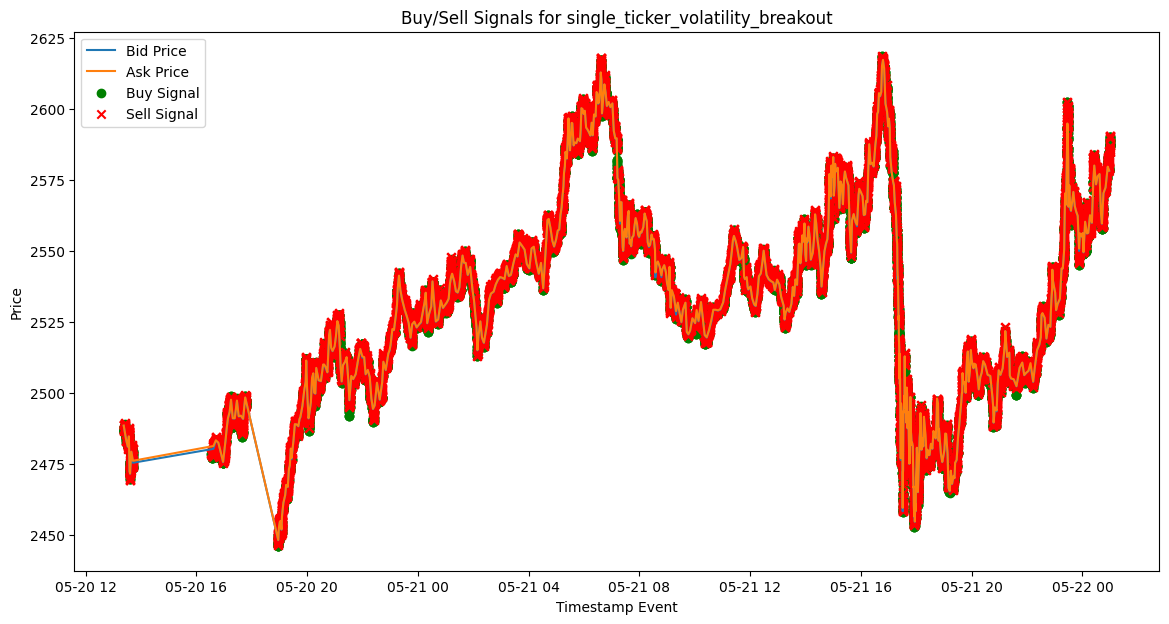

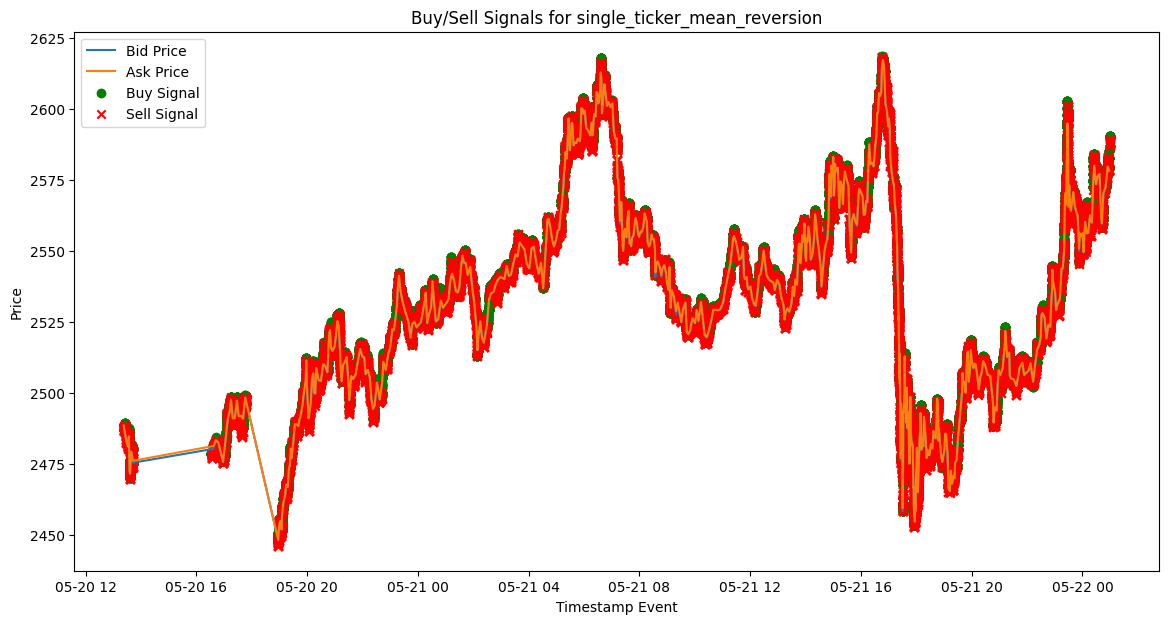

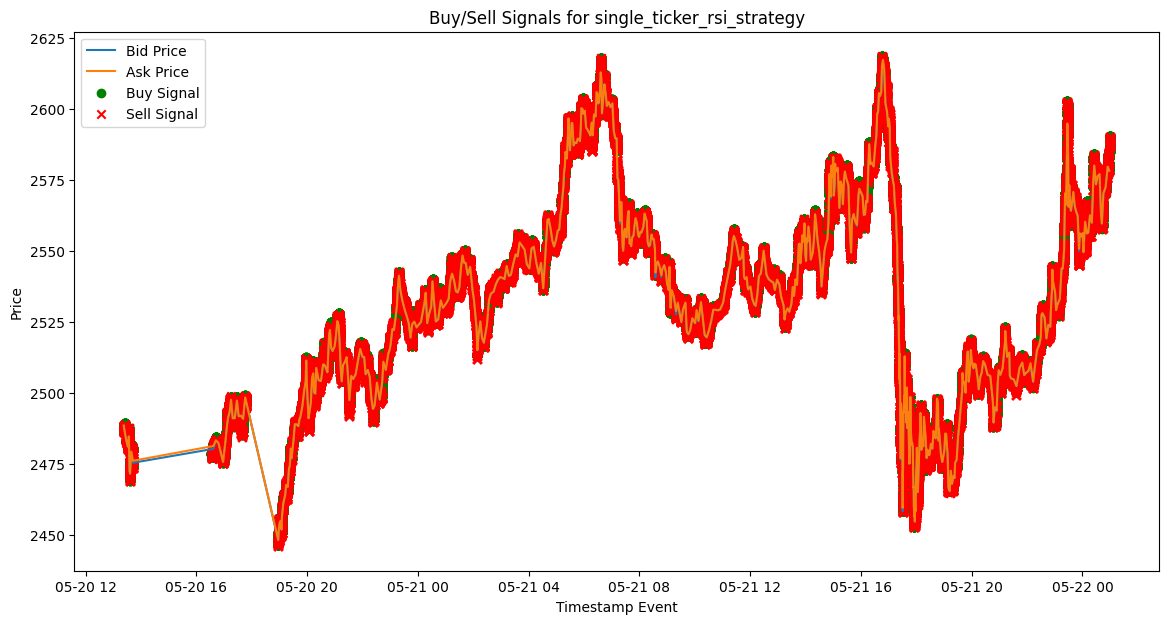

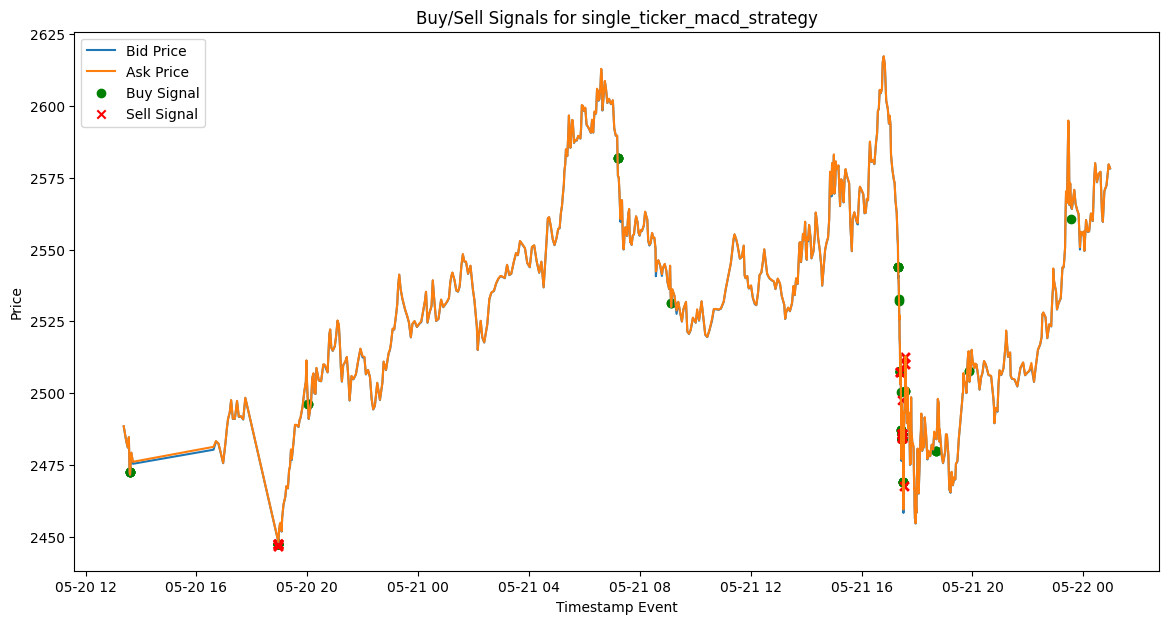

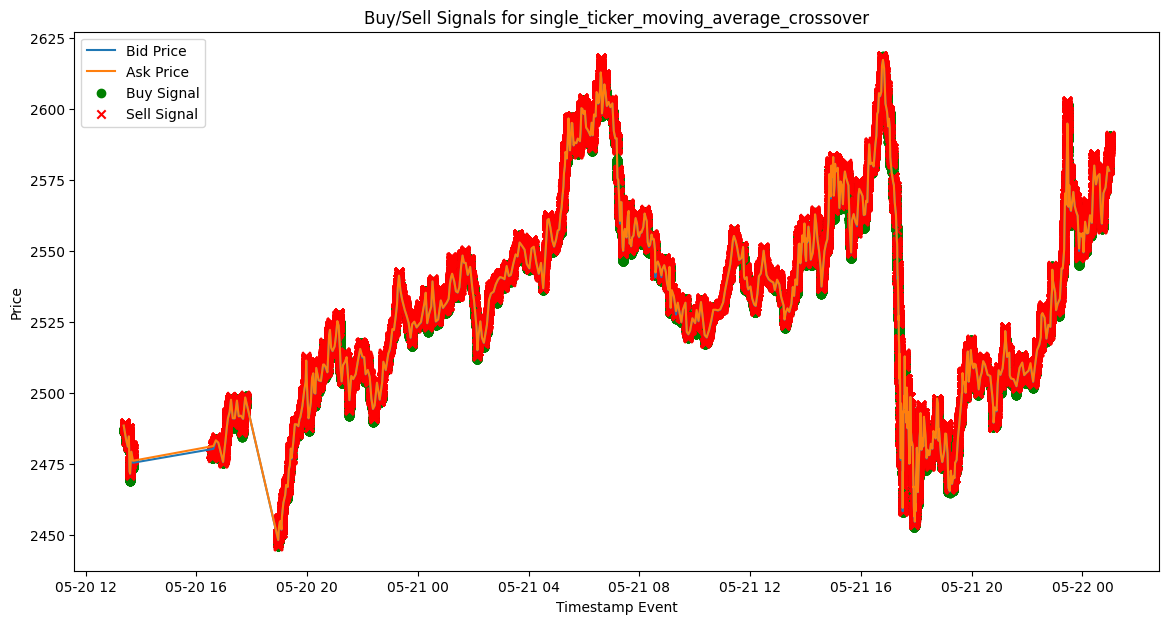

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the plot for buy/sell signals for each strategy
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Sample every 1000th row for the current strategy's output
    sampled_df = output_df.iloc[::1000, :]

    plt.figure(figsize=(14, 7))
    sns.lineplot(data=sampled_df, x='timestampEvent', y='bidPrice0', label='Bid Price')
    sns.lineplot(data=sampled_df, x='timestampEvent', y='askPrice0', label='Ask Price')
    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title('Bid and Ask Prices')


    # Add green and red dots for actions specific to each strategy
    buy_signals = output_df[output_df[f'{action_name}_cash_action'] > 0]
    sell_signals = output_df[output_df[f'{action_name}_cash_action'] < 0]

    plt.scatter(buy_signals['timestampEvent'], buy_signals['askPrice0'], color='green', label='Buy Signal', marker='o')
    plt.scatter(sell_signals['timestampEvent'], sell_signals['askPrice0'], color='red', label='Sell Signal', marker='x')

    plt.xlabel('Timestamp Event')
    plt.ylabel('Price')
    plt.title(f'Buy/Sell Signals for {action_name}')
    plt.legend()
    plt.show()


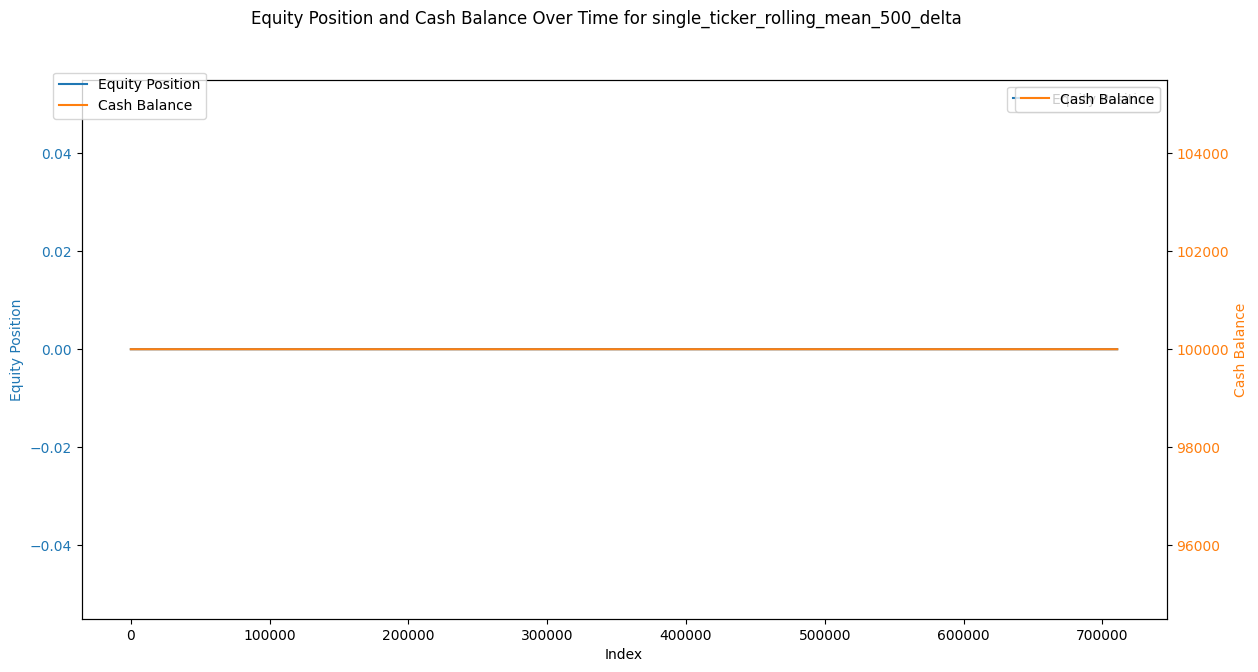

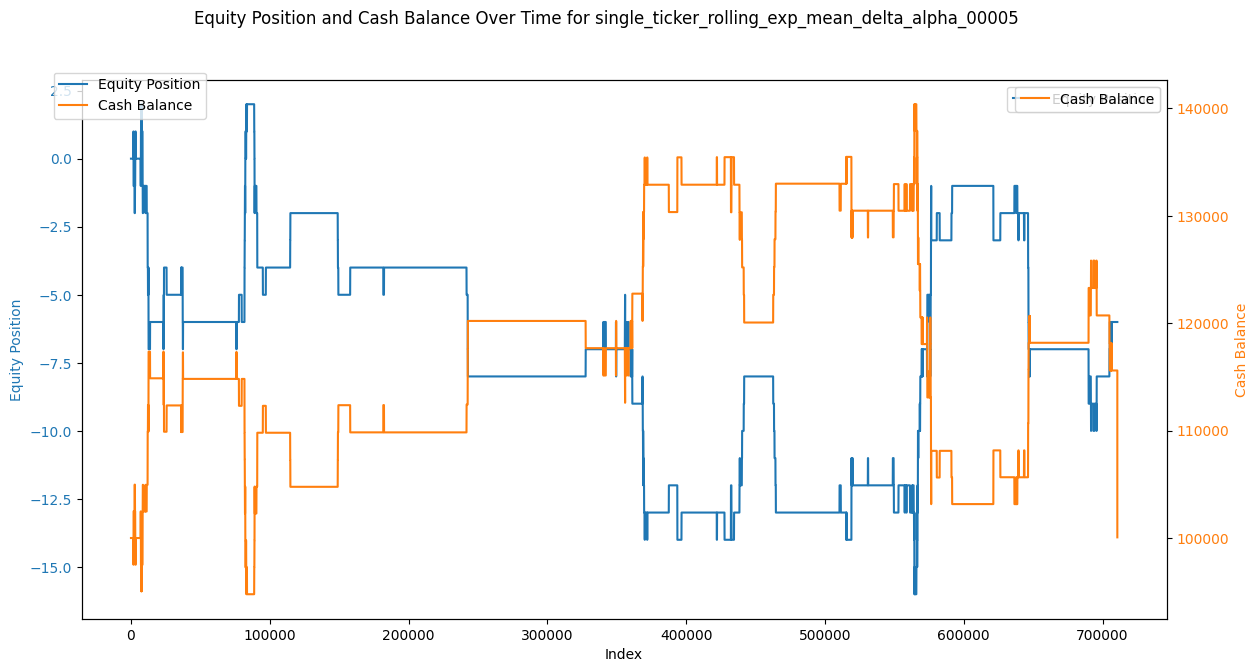

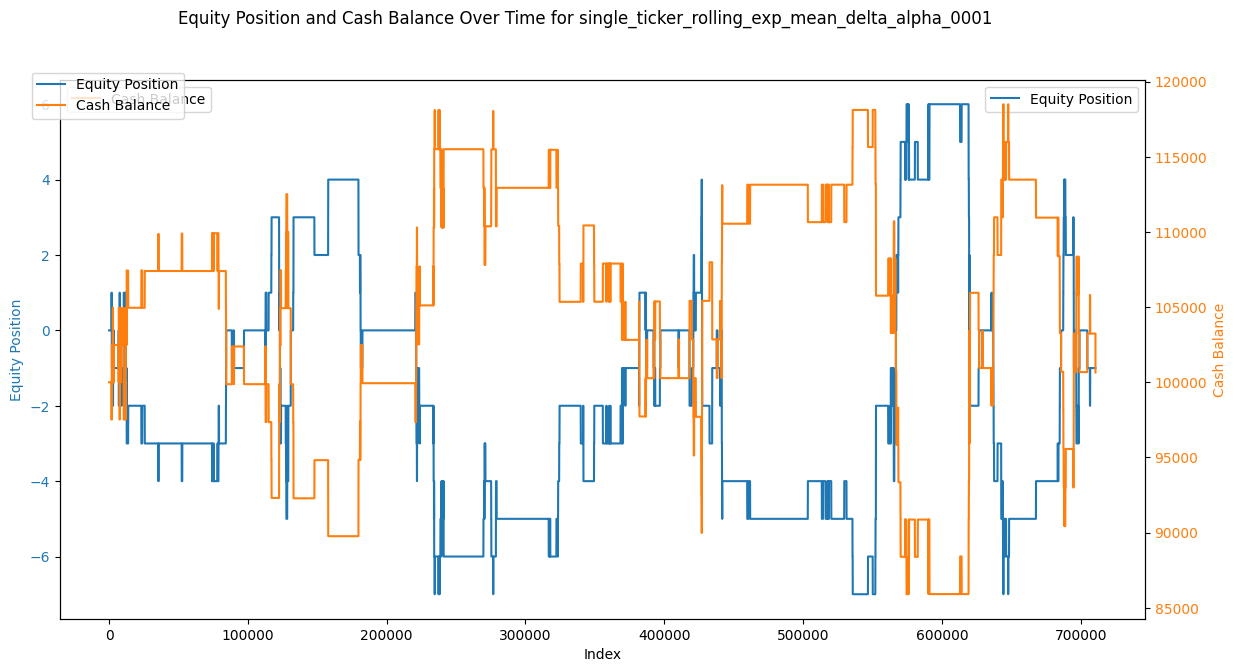

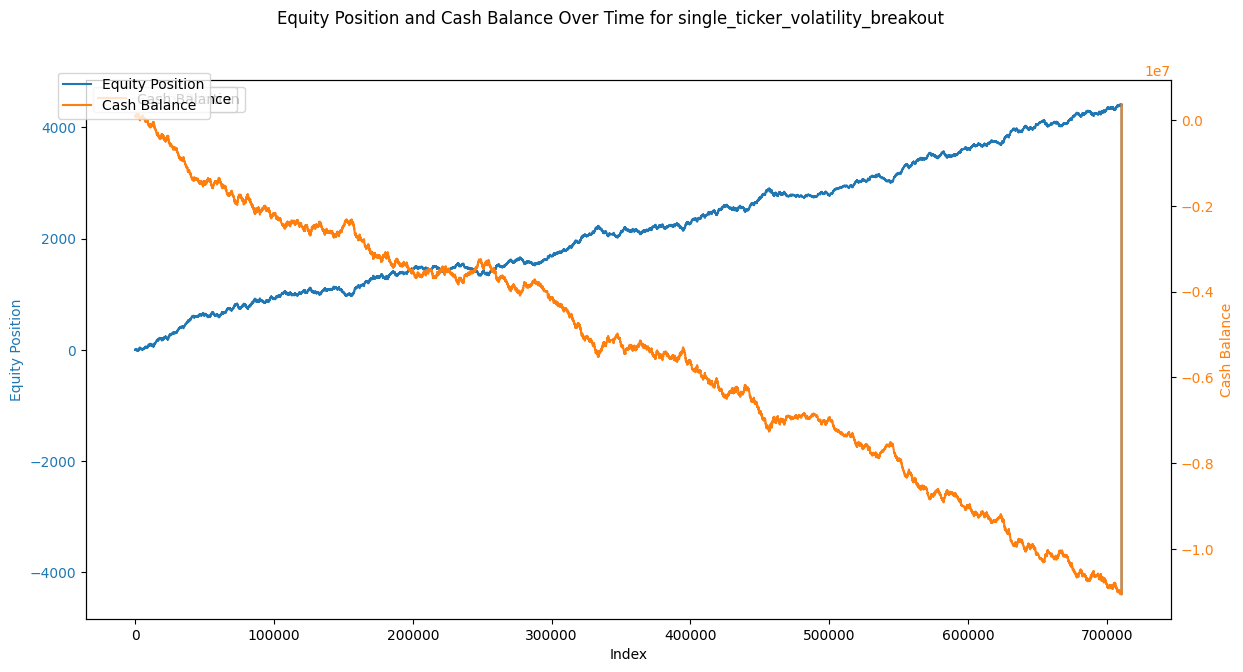

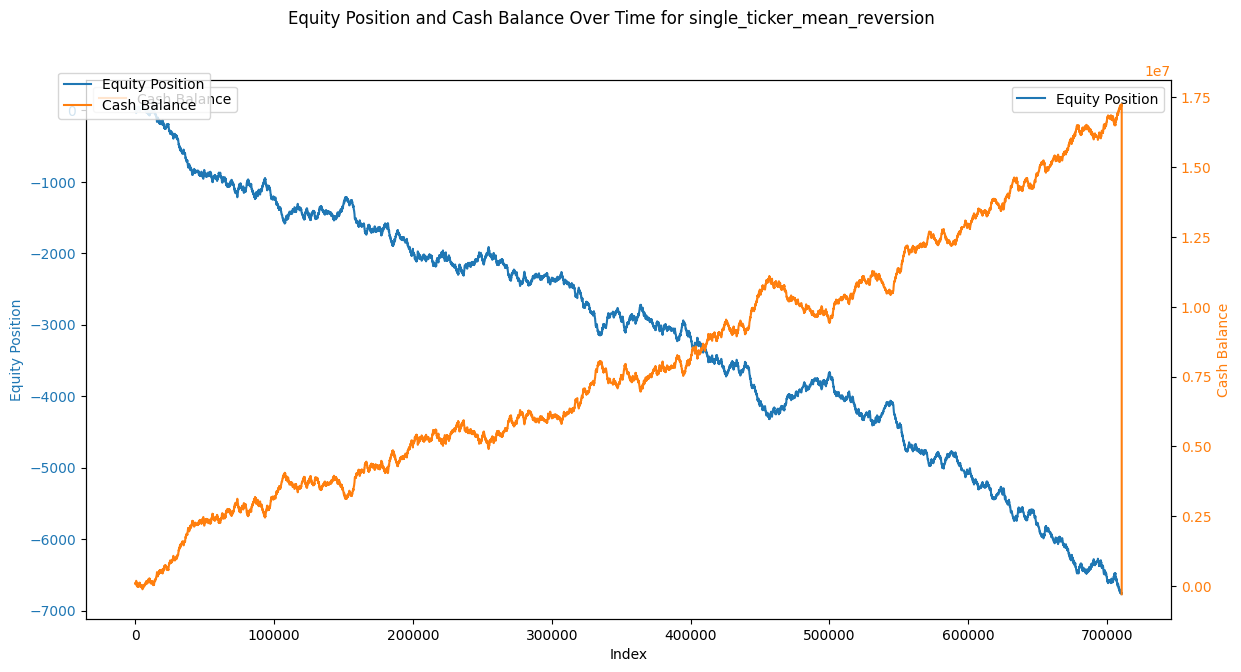

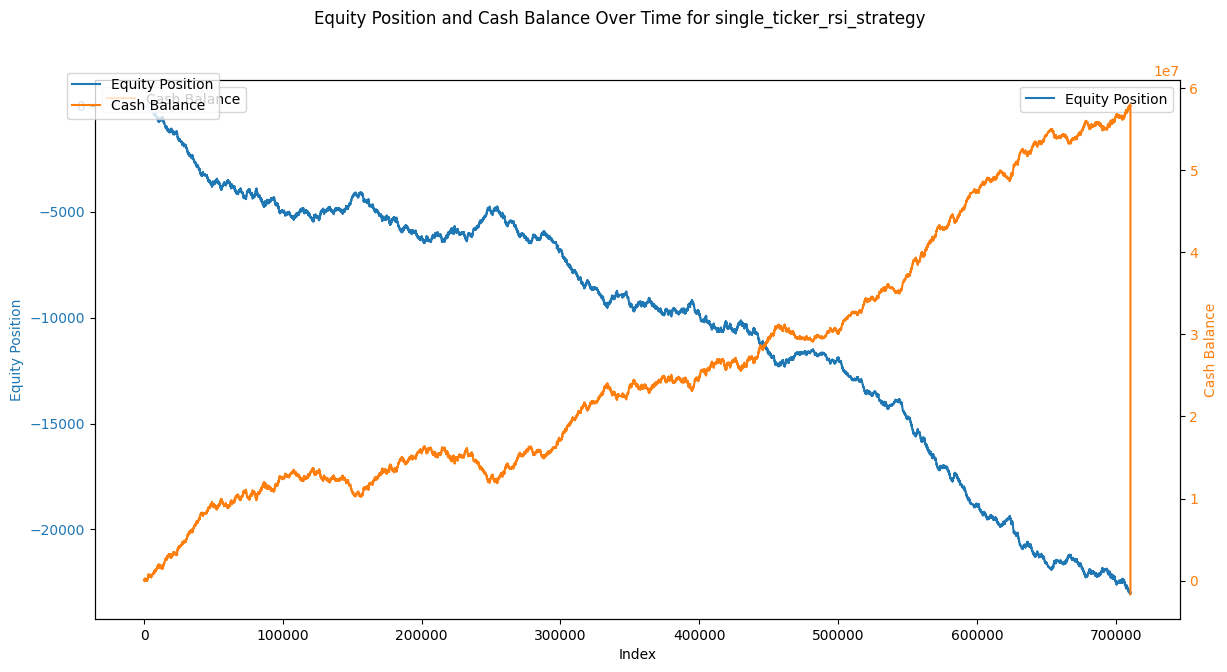

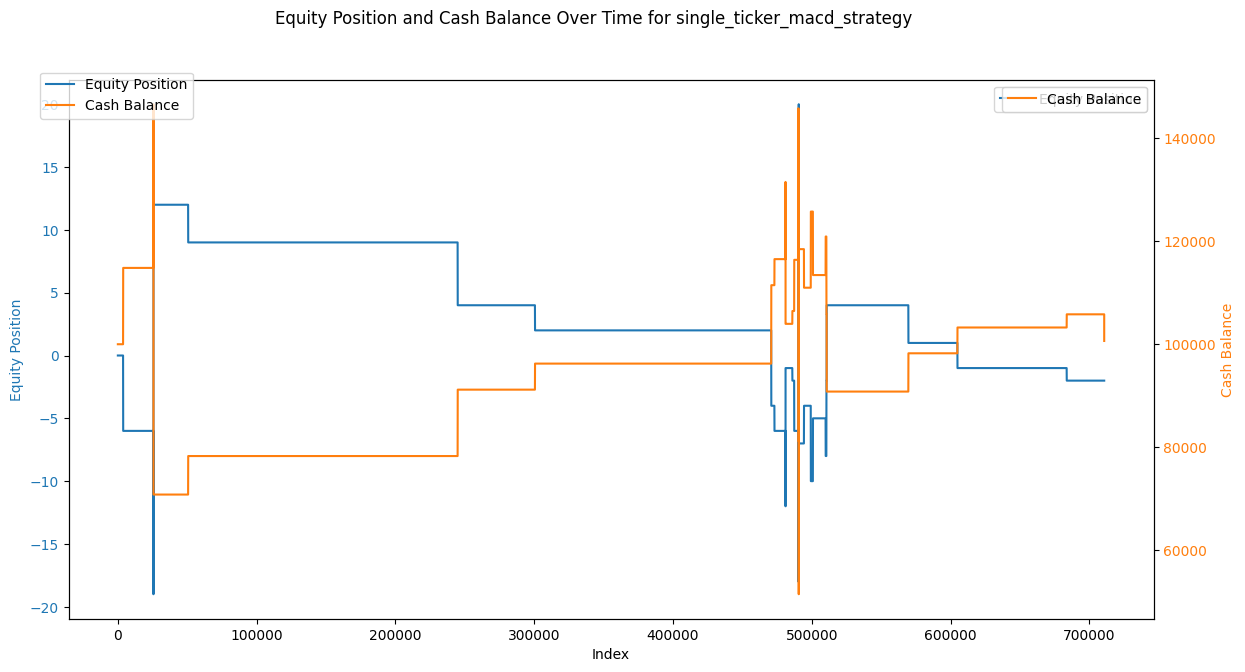

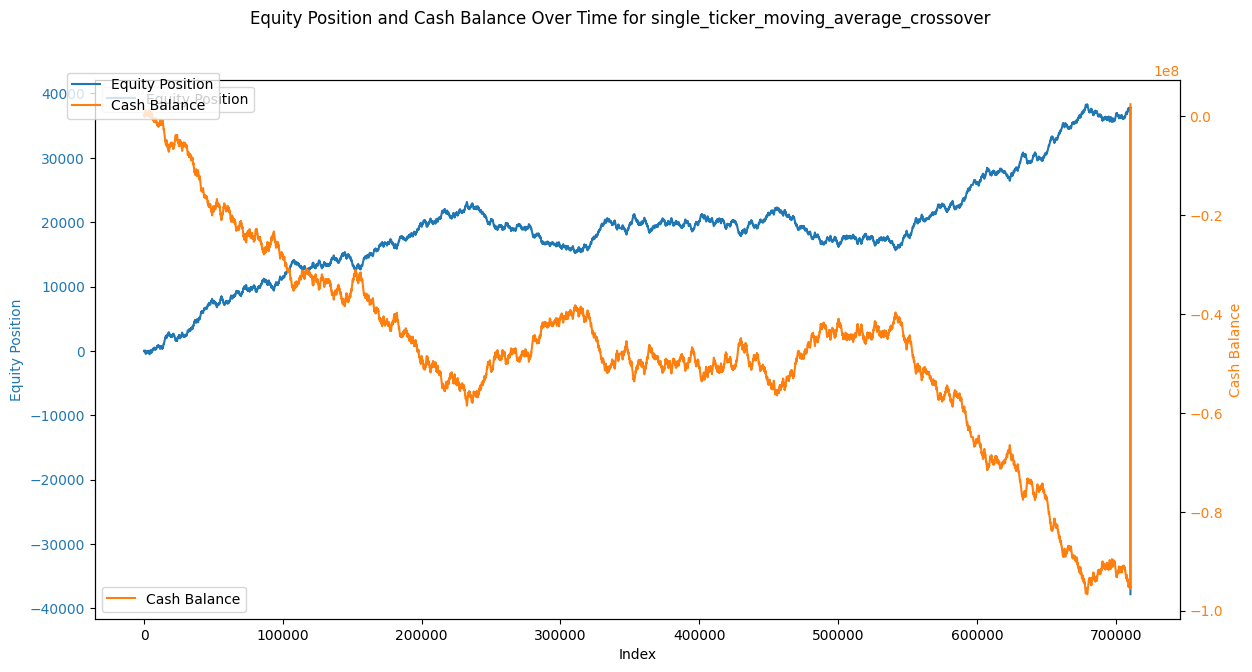

In [21]:
for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot Equity Position on the first y-axis
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Equity Position', color='tab:blue')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_equity_position', label='Equity Position', ax=ax1, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for Cash Balance
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cash Balance', color='tab:orange')
    sns.lineplot(data=output_df, x=output_df.index, y=f'{action_name}_cash_balance', label='Cash Balance', ax=ax2, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Add title and legend
    fig.suptitle(f'Equity Position and Cash Balance Over Time for {action_name}')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

    plt.show()

In [22]:
# Initialize a dictionary to store metrics for each strategy
strategy_metrics = {}

for strategy, outputs in zip(strategies, outputs_list):
    action_name = strategy.action.name
    output_df = outputs[0]

    # Classify each row into volatility categories based on ewm volatility
    ewm_volatility = output_df['bidPrice0'].ewm(span=20000, adjust=False).std()
    volatility_thresholds = ewm_volatility.quantile([0.33, 0.66])
    output_df['volatility_category'] = pd.cut(
        ewm_volatility,
        bins=[-float('inf'), volatility_thresholds[0.33], volatility_thresholds[0.66], float('inf')],
        labels=['low', 'medium', 'high']
    )

    # Initialize a dictionary to store metrics for each volatility zone
    strategy_metrics[action_name] = {}

    # Calculate and store advanced HFT metrics for each volatility zone
    for volatility_zone in ['low', 'medium', 'high']:
        zone_df = output_df[output_df['volatility_category'] == volatility_zone]

        # Identify sectors within the volatility zone
        zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()

        # Calculate metrics at the sector level
        sector_metrics = []
        for sector, sector_df in zone_df.groupby('sector'):
            mean_bid_price = sector_df['bidPrice0'].mean()
            mean_ask_price = sector_df['askPrice0'].mean()
            total_trades = len(sector_df[sector_df[f'{action_name}_cash_action'] != 0])
            profit_factor = (sector_df[f'{action_name}_cash_balance'].iloc[-1] - strategy.starting_cash) / strategy.starting_cash if strategy.starting_cash != 0 else float('inf')
            number_of_buys = len(sector_df[sector_df[f'{action_name}_cash_action'] > 0])
            number_of_sells = len(sector_df[sector_df[f'{action_name}_cash_action'] < 0])

            sector_metrics.append({
                'mean_bid_price': mean_bid_price,
                'mean_ask_price': mean_ask_price,
                'total_trades': total_trades,
                'profit_factor': profit_factor,
                'number_of_buys': number_of_buys,
                'number_of_sells': number_of_sells
            })
        
    
        # Calculate mean and std of the sector metrics at the volatility level
        mean_metrics = {key: np.mean([sector[key] for sector in sector_metrics]) for key in sector_metrics[0]}
        std_metrics = {key: np.std([sector[key] for sector in sector_metrics]) for key in sector_metrics[0]}

        # Store the metrics for each strategy and volatility zone
        strategy_metrics[action_name][volatility_zone] = {
            'mean_metrics': mean_metrics,
            'std_metrics': std_metrics,
            "all_metrics": sector_metrics
        }

# Now strategy_metrics contains all the metrics for each strategy and volatility zone


/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_5539/3536110269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_5539/3536110269.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zone_df['sector'] = (zone_df.index.to_series().diff() != 1).cumsum()
/var/folders/xs/59kj_n6d2qs33ypnrkskvyzh0000gn/T/ipykernel_5539/3536110269.py:25: SettingWithCopyWarning: 
A value is 

In [24]:
# Create a DataFrame from strategy_metrics for each strategy and volatility zone
all_metrics_df = pd.DataFrame([
    {
        'Strategy': strategy,
        'Volatility': volatility_zone,
        'Profit Factor': metric['profit_factor']
    }
    for strategy in strategy_metrics
    for volatility_zone in strategy_metrics[strategy]
    for metric in strategy_metrics[strategy][volatility_zone]['all_metrics']
])
all_metrics_df

,Strategy,Volatility,Profit Factor
0,single_ticker_rolling_mean_500_delta,low,0.000000
1,single_ticker_rolling_mean_500_delta,low,0.000000
2,single_ticker_rolling_mean_500_delta,low,0.000000
3,single_ticker_rolling_mean_500_delta,low,0.000000
4,single_ticker_rolling_mean_500_delta,low,0.000000
...,...,...,...
555,single_ticker_moving_average_crossover,high,-504.721656
556,single_ticker_moving_average_crossover,high,-694.899354
557,single_ticker_moving_average_crossover,high,-872.465482
558,single_ticker_moving_average_crossover,high,-906.559737


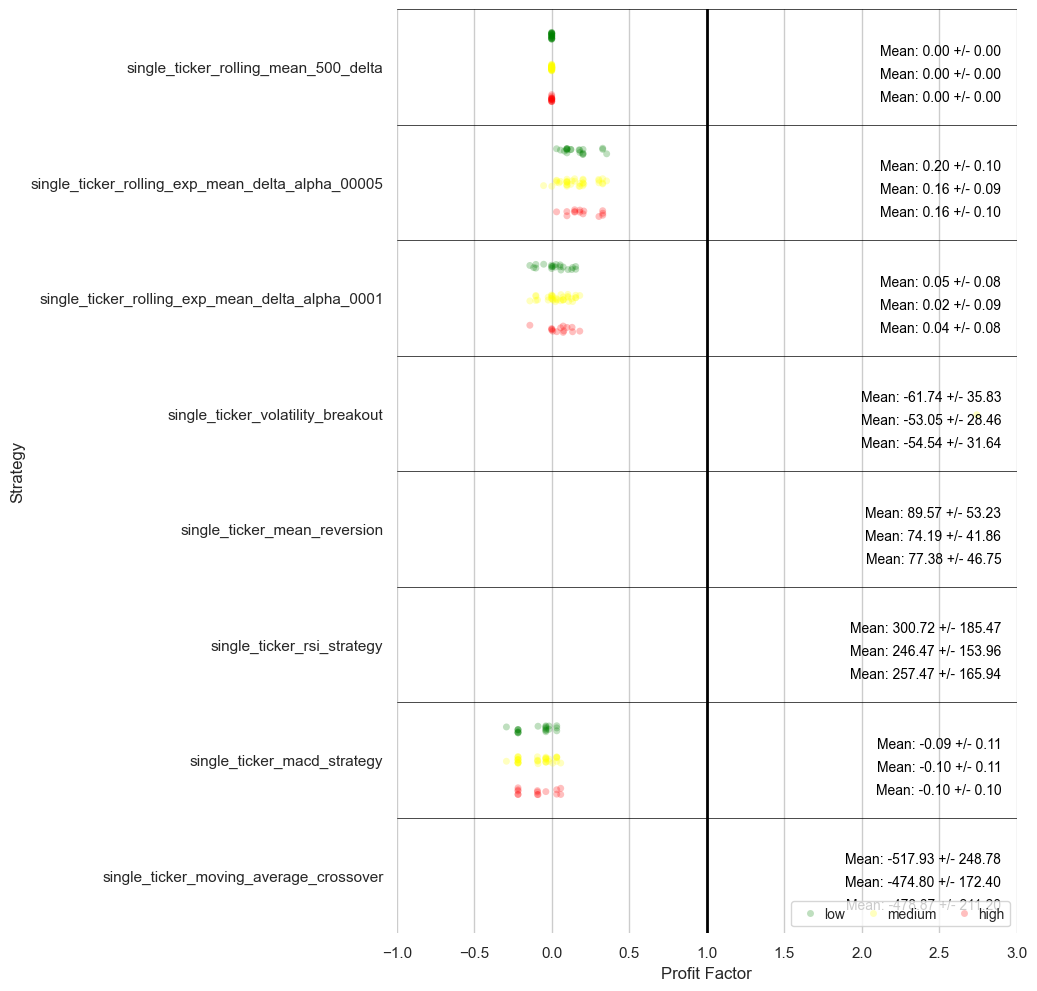

In [25]:
# Build the DataFrame using the mean and std metrics
profit_factors_df = all_metrics_df

# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Initialize the figure with increased height to space strategies more
f, ax = plt.subplots(figsize=(8, 12))  # Adjust the height to space out the strategies
sns.despine(bottom=True, left=True)

# Define a custom palette for volatility levels
custom_palette = {'low': 'green', 'medium': 'yellow', 'high': 'red'}

# Show each observation with a scatterplot
sns.stripplot(
    data=profit_factors_df, x="Profit Factor", y="Strategy", hue="Volatility",
    dodge=True, alpha=.25, zorder=1, palette=custom_palette
)

# Add mean and std as black font labels next to each stripplot for each volatility zone
for i, (strategy, strategy_df) in enumerate(profit_factors_df.groupby('Strategy')):
    # Ensure the subplot's stripplot strategy matches the strategy of the mean being printed
    strategy_index = profit_factors_df['Strategy'].unique().tolist().index(strategy)
    for j, (volatility, volatility_df) in enumerate(strategy_df.groupby('Volatility')):
        strategy_volatility_data = volatility_df['Profit Factor']
        mean = strategy_volatility_data.mean()
        std = strategy_volatility_data.std()
        # Align the text horizontally with the respective volatility zones
        ax.text(2.9, strategy_index + j * 0.2 - 0.2, f'Mean: {mean:.2f} +/- {std:.2f}', color='black', ha='right', va='top', fontsize='small')

# Add a bold black vertical line at 1
ax.axvline(x=1, color='black', linewidth=2, linestyle='-')

# Set the x-axis limits from 0 to 2
ax.set_xlim(-1, 3)

# Add horizontal lines to separate each row
for ytick in range(len(ax.get_yticks()) + 1):
    ax.axhline(y=ytick - 0.5, color='black', linewidth=0.5, linestyle='-')

# Add the legend manually since move_legend requires an existing legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0, fontsize='small')

plt.show()